# Abgabe 3

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io

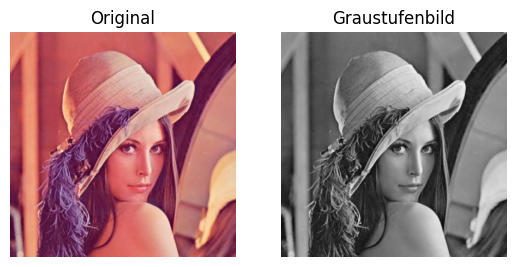

In [114]:
#load images
images = []
for file in os.listdir('.'):
    if file.endswith(('.jpg', '.png')):
        img = io.imread(file)
        images.append(img)

#convert to gray image 
def gray_converter(image):
    gray_image = 0.2989 * image[:, :, 2] + 0.5870 * image[:, :, 1] + 0.1140 * image[:, :, 0]
    gray_image = gray_image.astype('uint8')
    return gray_image

gray_image = gray_converter(images[0])

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(images[0])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Graustufenbild")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')
 
plt.show()



2. Implementierung der Faltung mit Filtermasken

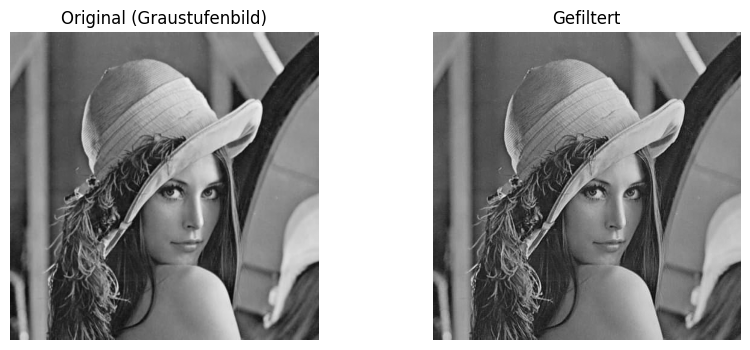

In [132]:
gauss_filter = np.array([[1, 2, 1],
                         [2, 4, 2],
                         [1, 2, 1]], dtype=float)

sharpen_filter = np.array([[ 0, -1,  0],
                           [-1,  8, -1],
                           [ 0, -1,  0]], dtype=float)

laplacian_filter = np.array([[0, 1, 0],
                        [1,  -4, 1],
                        [0, 1, 0]], dtype=float)

laplacian_5x5 = np.array([[0,  0, -1,  0,  0],
                         [0, -1, -2, -1,  0],
                         [-1, -2, 16, -2, -1],
                         [0, -1, -2, -1,  0],
                         [0,  0, -1,  0,  0]], dtype=float)


def filter(in_image, filter, off):

    image_h, image_w = in_image.shape
    filter_h, filter_w = filter.shape

    s = 1.0 if np.sum(filter) == 0 else 1.0 / np.sum(filter) #normalization

    #filter matrix (2K+1)×(2L+1) (radius)
    K = filter_w // 2 
    L = filter_h // 2

    copy = in_image.copy()
    #out_image = np.zeros_like(in_image)
    out_image = in_image.copy()

    for v in range(L, image_h - L, off):
        for u in range(K, image_w - K, off):
            sum = 0.0
            for j in range(- L, L + 1):
                for i in range(- K, K + 1):
                    p = copy[v + j, u + i] #[y,x] pixel
                    c = filter[j + L, i + K] #weight
                    sum += c * p
            
            q = int(np.round(s * sum))
            if q < 0: q = 0
            if q > 255: q = 255 #clipping
            out_image[v, u] = q
    
    return out_image

#filtered_img = filter(gray_image, gauss_filter, 1)
filtered_img = filter(gray_image, sharpen_filter, 1)
#filtered_img = filter(gray_image, laplacian_filter, 1)
#filtered_img = filter(gray_image, laplacian_5x5 , 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original (Graustufenbild)")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Gefiltert")
plt.imshow(filtered_img, cmap='gray')
plt.axis('off')

plt.show()


3. Erweiterung des filter() - Methode

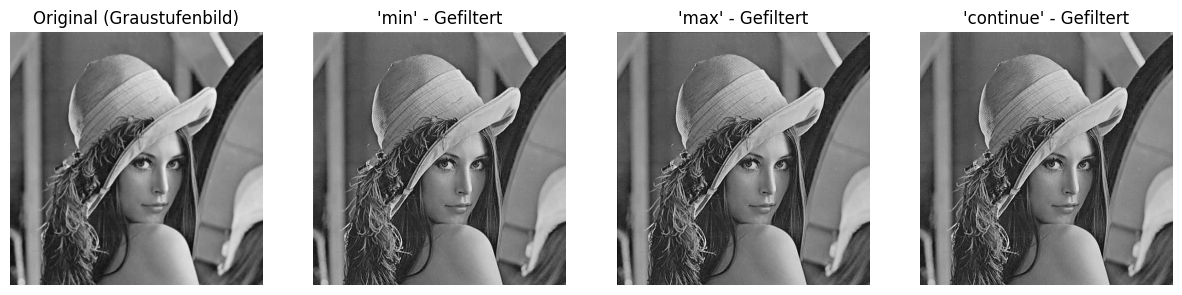

Original:
[[143 142 142 ... 152 135 110]
 [143 143 143 ... 146 128 104]
 [144 144 142 ... 148 132 110]
 ...
 [ 37  39  43 ...  84  84  84]
 [ 38  40  44 ...  87  87  88]
 [ 39  41  45 ...  85  87  88]]

Gefiltert mit 'min':
[[215 177 177 ... 184 191 196]
 [178 142 146 ... 144 140 153]
 [180 148 138 ... 144 145 152]
 ...
 [ 49  46  48 ...  76  79  76]
 [ 47  37  44 ...  78  80  77]
 [ 46  36  43 ...  84  86  84]]

Gefiltert mit 'max':
[[ 87 113 113 ... 120 127 132]
 [115 142 146 ... 144 140 153]
 [116 148 138 ... 144 145 152]
 ...
 [  0  46  48 ...  76  79  76]
 [  0  37  44 ...  78  80  77]
 [  0  36  43 ...  84  86  84]]

Gefiltert mit 'continue':
[[143 142 142 ... 147 153 158]
 [143 142 146 ... 144 140 153]
 [144 148 138 ... 144 145 152]
 ...
 [ 39  46  48 ...  76  79  76]
 [ 38  37  44 ...  78  80  77]
 [ 36  36  43 ...  84  86  84]]


In [131]:
def filter2(in_image, filter, off, edge):

    image_h, image_w = in_image.shape
    filter_h, filter_w = filter.shape

    s = 1.0 if np.sum(filter) == 0 else 1.0 / np.sum(filter) #normalization

    #filter matrix (2K+1)×(2L+1)
    K = filter_w // 2
    L = filter_h // 2

    out_h = (image_h - filter_h) // off + 1
    out_w = (image_w - filter_w) // off + 1
    out_image = np.zeros((out_h, out_w), dtype=np.uint8)
    
    copy_image = in_image.copy()

    for v in range(0, out_h, off):
        for u in range(0, out_w, off):
            sum = 0.0
            for j in range(- L, L + 1):
                for i in range(- K, K + 1):

                    x = u + i
                    y = v + j

                    if 0 <= x < image_w and 0 <= y < image_h:
                        p = copy_image[y, x]
                    else:
                        if edge == 'min':
                            p = 0
                        elif edge == 'max':
                            p = 255
                        elif edge == 'continue':
                            x = min(max(x, 0), image_w - 1)
                            y = min(max(y, 0), image_h - 1)
                            p = copy_image[y, x]    

                    c = filter[j + L, i + K]
                    sum += c * p
            
            q = int(np.round(s * sum))
            if q < 0: q = 0
            if q > 255: q = 255
            out_image[v, u] = q
        
    return out_image

min_filtered_img = filter2(filtered_img, sharpen_filter, 1, 'min')
max_filtered_img = filter2(filtered_img, sharpen_filter, 1, 'max')
continue_filtered_img = filter2(filtered_img, sharpen_filter,  1, 'continue')

#min_filtered_img = filter2(gray_image, gauss_filter, 1, 'min')
#max_filtered_img = filter2(gray_image, gauss_filter, 1, 'max')
#continue_filtered_img = filter2(gray_image, gauss_filter, 1, 'continue')

#min_filtered_img = filter2(gray_image, laplacian_filter, 1, 'min')
#max_filtered_img = filter2(gray_image, laplacian_filter, 1, 'max')
#continue_filtered_img = filter2(gray_image, laplacian_filter, 1, 'continue')

plt.figure(figsize=(15, 9))

plt.subplot(1, 4, 1)
plt.title("Original (Graustufenbild)")
plt.imshow(gray_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("'min' - Gefiltert")
plt.imshow(min_filtered_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("'max' - Gefiltert")
plt.imshow(max_filtered_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("'continue' - Gefiltert")
plt.imshow(continue_filtered_img, cmap='gray')
plt.axis('off')

plt.show()

np.set_printoptions(linewidth=120, threshold=1000)

print("Original:")
print(gray_image)

print("\nGefiltert mit 'min':")
print(min_filtered_img)

print("\nGefiltert mit 'max':")
print(max_filtered_img)

print("\nGefiltert mit 'continue':")
print(continue_filtered_img)

**Untersuchung der Randbehandlungen bei verschiedenen Filtern**

1. **'min' (Zero Padding)**
- Randwerte = 0
  - Gaussfilter: Dunklere Ränder, weiche Übergänge
  - Schärfungsfilter: Unnatürliche Kanten
  - Laplacian-Filter: Abschwächung der Ränder

2. **'max' (255 Padding)**
- Randwerte = 255
  - Gaussfilter: Hellerer Rand, verstärkter Übergang
  - Schärfungsfilter: Überbetonte Kanten
  - Laplacian-Filter: Kanten am Rand

3. **'continue' (Fortsetzung)**
- Randwerte werden mit benachbarten Pixelwerten fortgesetzt
  - Alle Filter: Natürliche Übergänge